# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Inicialización

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer

### Cargar datos

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv(r'\datasets\taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Se realizó el cambio de tipo *object* de la columna **datetime** a tipo *datetime* en la carga de datos, además de colocar como índice mencionada columna.

In [5]:
#erificamos que se encuentra en orden cronologico
df=df.sort_index()
df.index.is_monotonic

True

## Análisis

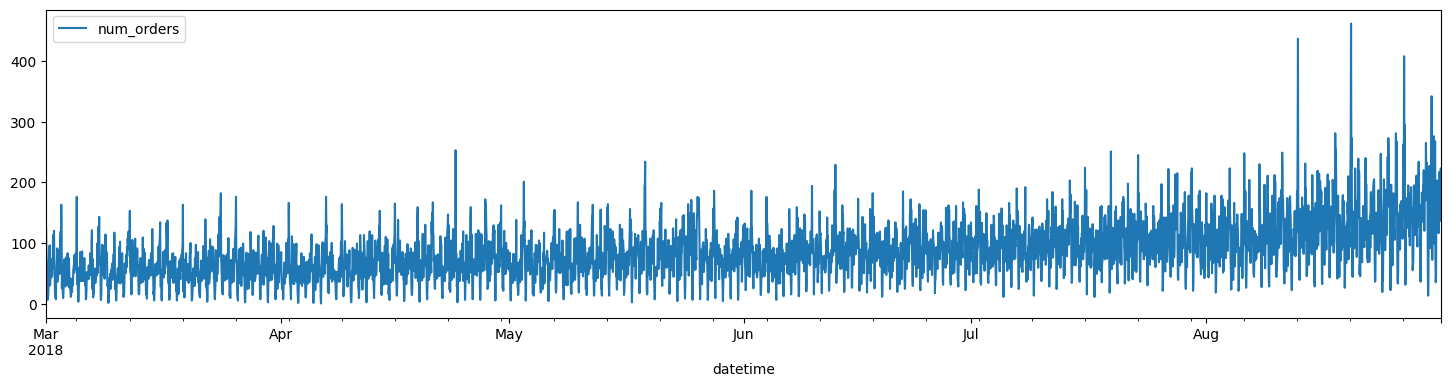

In [6]:
df_resampled = df.resample('1H').sum()
df_resampled.plot(figsize=[18,4])
plt.show()

In [7]:
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
decomposed = seasonal_decompose(df_resampled)

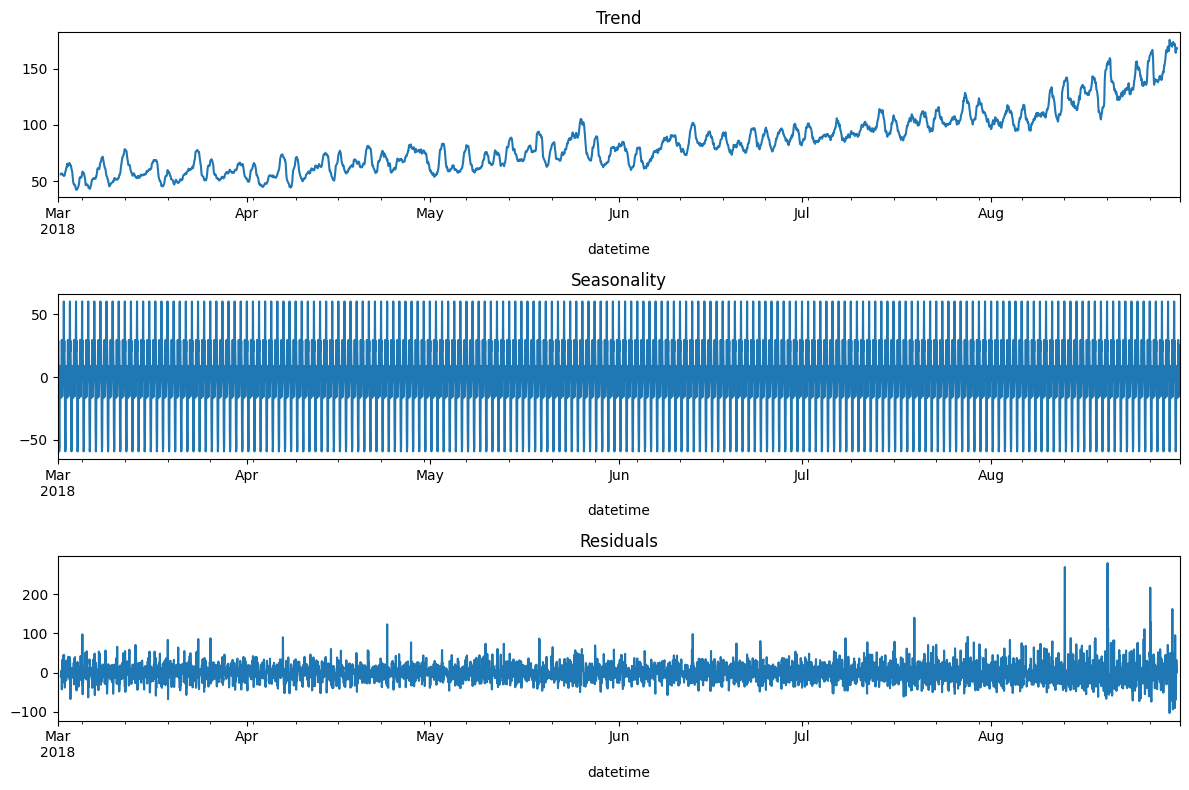

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Observamos que el pico de fines de mes de Mayo en la tendencia es superado en el mes de Agosto, donde se aprecia que las ordenes van en aumento.

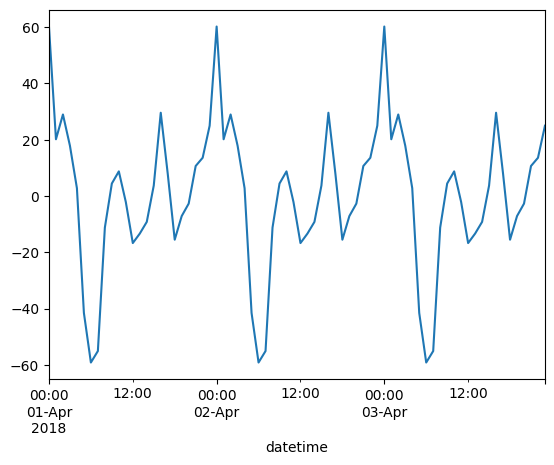

In [10]:
decomposed.seasonal[744:816].plot(ax = plt.gca())
plt.show()

Al trazar un gráfico de 3 días, el pedido de taxis a las 18:00 empieza a subir los pedidos hasta alcanzar su pico a medianoche, mientras que en la mañana luego de su descenso hasta las 6:00, empieza a subir las ordenes, lo cual podría ser por personas que requieren ir a su trabajo, universidades, entre otros.

In [11]:
#Descomposición por día
df_resampled_day = df_resampled.resample('1D').sum()
decomposed_day = seasonal_decompose(df_resampled_day)

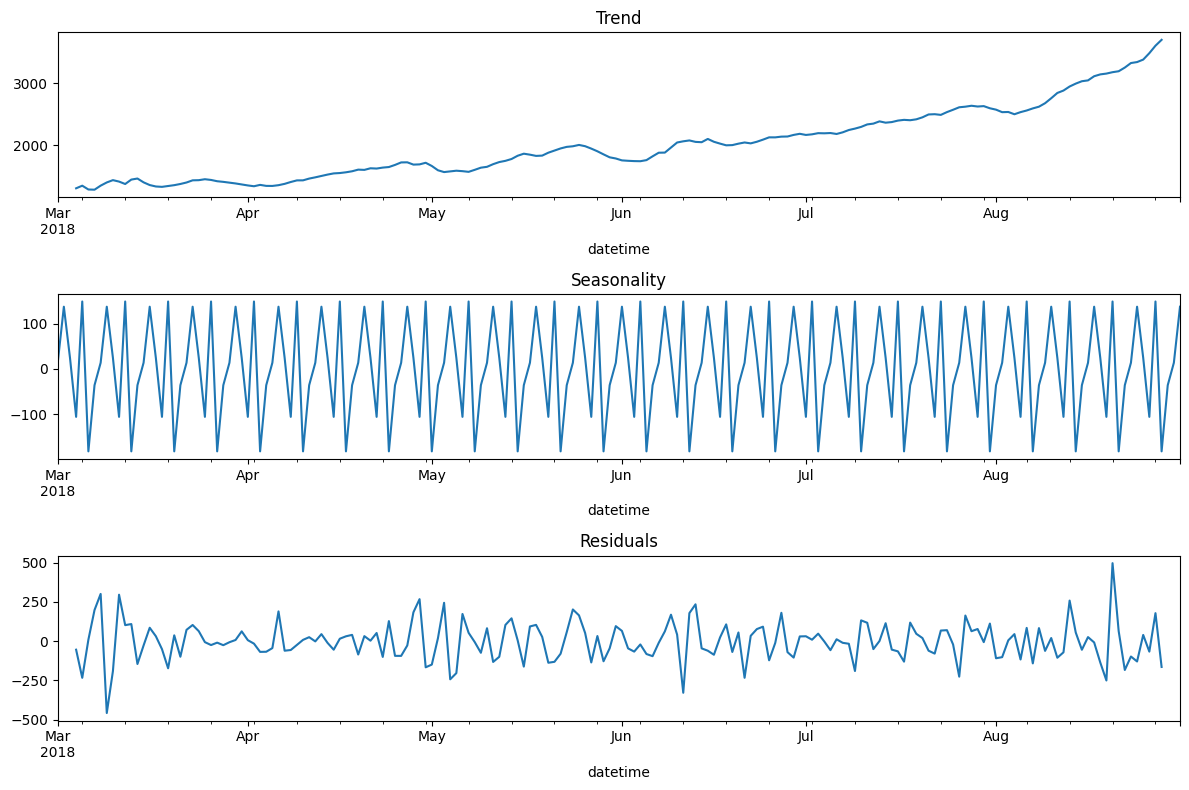

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Se obseva que la tendencia a aumentar va desde el mes de Julio y continua en ascenso en Agosto.

In [13]:
#Descomposición por día del mes de Junio
df_resampled_day = df_resampled['2018-06-01':'2018-06-30'].resample('1D').sum()
decomposed_day = seasonal_decompose(df_resampled_day)

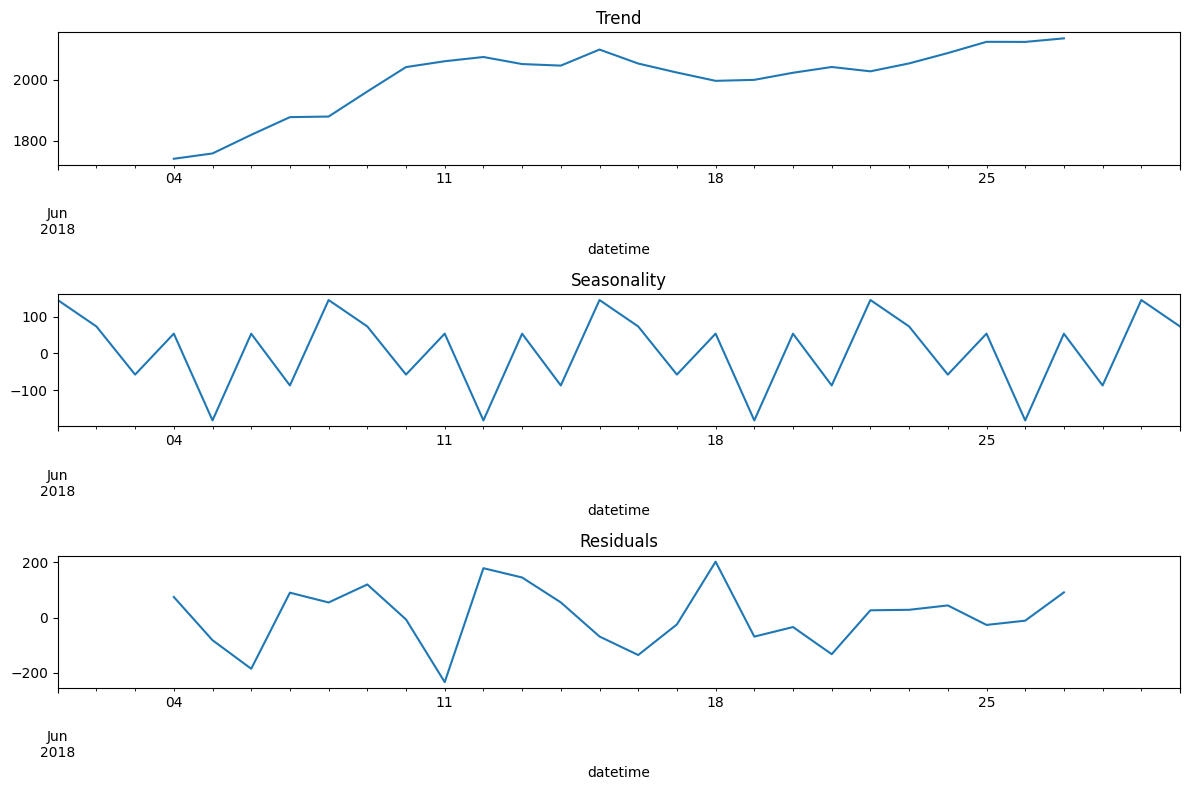

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Se observa que los fines desde semana se eleva el numero de ordenes de taxi.

## Formación

In [15]:
def make_features(df_resampled, max_lag, rolling_mean_size):
    df_resampled['year'] = df_resampled.index.year
    df_resampled['month'] = df_resampled.index.month
    df_resampled['day'] = df_resampled.index.day
    df_resampled['hour'] = df_resampled.index.hour
    df_resampled['dayofweek'] = df_resampled.index.dayofweek

    for lag in range(1, max_lag + 1):
        df_resampled['lag_{}'.format(lag)] = df_resampled['num_orders'].shift(lag)

    df_resampled['rolling_mean'] = (
        df_resampled['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df_resampled, 24, 6)

In [16]:
train, test = train_test_split(df_resampled, test_size = 0.1, shuffle = False)
train=train.dropna()

In [17]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [18]:
#funcion para el rmse
def meansqrt(y_real, y_pred):
    dif2 = (1/len(y_real))*np.sum((y_real - y_pred)**2)
    mesqrt = dif2**0.5
    return mesqrt
scorer = make_scorer(meansqrt, greater_is_better=False)

## Prueba

### Regresión lineal

In [19]:
model=LinearRegression()
model.fit(features_train, target_train)
pred_train=model.predict(features_train)
pred_test=model.predict(features_test)

rmse_rl = meansqrt(pred_test, target_test)
print("RECM para el conjunto de entrenamiento:", meansqrt(pred_train, target_train))
print("RECM para el conjunto de prueba:", rmse_rl)

RECM para el conjunto de entrenamiento: 25.699174244212355
RECM para el conjunto de prueba: 45.810948889069444


In [20]:
series_preds = pd.DataFrame(data={
    "prediction": pred_test,
    "target": target_test,
}, index=target_test.index)

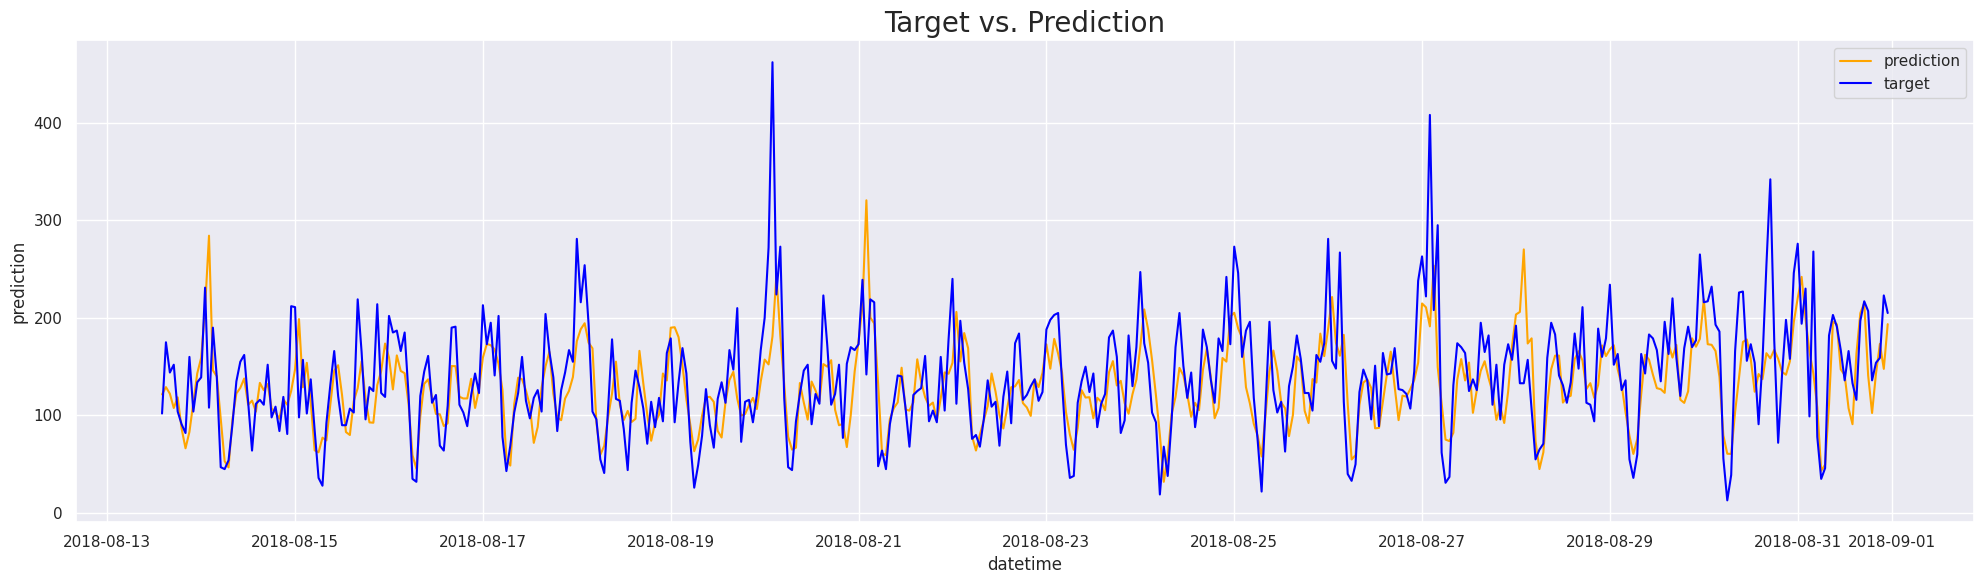

In [21]:
sns.set_theme()

plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds, x=series_preds.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds, x=series_preds.index, y="target", label="target", color="blue")
plt.title("Target vs. Prediction", size=20)
plt.tight_layout()

### Árbol de decisión

In [22]:
model_tree = DecisionTreeRegressor()
param_grid = {
    'max_depth':list(range(3,50)),
    'random_state':[12345]
}
grid_tree = GridSearchCV(estimator=model_tree, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_tree.fit(features_train, target_train)
best_param_tree=grid_tree.best_params_


In [23]:
print(best_param_tree)
print(-grid_tree.best_score_)

{'max_depth': 5, 'random_state': 12345}
28.11757412614603


In [24]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=5)
model_tree.fit(features_train, target_train)
pred_train=model_tree.predict(features_train)
pred_test=model_tree.predict(features_test)

rmse_tree = meansqrt(pred_test, target_test)
print("RECM para el conjunto de entrenamiento:", meansqrt(pred_train, target_train))
print("RECM para el conjunto de prueba:", rmse_tree)

RECM para el conjunto de entrenamiento: 24.685468094837084
RECM para el conjunto de prueba: 49.26126872704544


### Bosque aleatorio

In [25]:
model_forest = RandomForestRegressor()
param_grid = {
    'n_estimators':[20],
    'max_depth':list(range(3,15)),
    'random_state':[12345]
}
grid_forest = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_forest.fit(features_train, target_train)
best_param_forest=grid_forest.best_params_

print(best_param_forest)
print(-grid_forest.best_score_)

{'max_depth': 11, 'n_estimators': 20, 'random_state': 12345}
24.45713278721425


In [26]:
model_ba = RandomForestRegressor(random_state=12345, n_estimators=20, max_depth=11)
model_ba.fit(features_train, target_train)
pred_train=model_ba.predict(features_train)
pred_test=model_ba.predict(features_test)

rmse_ba = meansqrt(pred_test, target_test)
print("RECM para el conjunto de entrenamiento:", meansqrt(pred_train, target_train))
print("RECM para el conjunto de prueba:", rmse_ba)

RECM para el conjunto de entrenamiento: 13.953303709434655
RECM para el conjunto de prueba: 44.428970512368295


### LightGBM

In [27]:
model_lgbm = LGBMRegressor()
param_grid = {
    'n_estimators':[20, 50],
    'seed':[12345],
    'max_depth':list(range(3, 15)),
    'objective':['regression_l2'],
    'learning_rate':[0.05, 0.4]
}

grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_lgbm.fit(features_train, target_train)
best_param_lgbm=grid_lgbm.best_params_

print(best_param_lgbm)
print(-grid_lgbm.best_score_)

{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 50, 'objective': 'regression_l2', 'seed': 12345}
23.796389376884484


In [28]:
model_lgbm = LGBMRegressor(n_estimators=50, seed=12345, max_depth=3, objective='regression_l2', learning_rate=0.4)
model_lgbm.fit(features_train, target_train)
pred_train=model_lgbm.predict(features_train)
pred_test=model_lgbm.predict(features_test)

rmse_lgbm = meansqrt(pred_test, target_test)
print("RECM para el conjunto de entrenamiento:", meansqrt(pred_train, target_train))
print("RECM para el conjunto de prueba:", rmse_lgbm)

RECM para el conjunto de entrenamiento: 18.228777227420153
RECM para el conjunto de prueba: 42.214170599541305


### CatBoost

In [29]:
model_cat = CatBoostRegressor()
param_grid = {
    'n_estimators':[20, 50],
    'random_seed':[12345],
    'max_depth':list(range(3, 15)),
    'loss_function':['RMSE'],
    'learning_rate':[0.05, 0.4],
    'l2_leaf_reg':[0.5]
}

grid_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_cat.fit(features_train, target_train)
best_param_cat=grid_cat.best_params_

print(best_param_cat)
print(-grid_cat.best_score_)

0:	learn: 38.0953686	total: 49.8ms	remaining: 946ms
1:	learn: 37.4141164	total: 52.8ms	remaining: 475ms
2:	learn: 36.7769627	total: 55.8ms	remaining: 316ms
3:	learn: 36.1072797	total: 59ms	remaining: 236ms
4:	learn: 35.5927157	total: 62ms	remaining: 186ms
5:	learn: 35.0547656	total: 64.7ms	remaining: 151ms
6:	learn: 34.5168692	total: 67.7ms	remaining: 126ms
7:	learn: 34.0398985	total: 70.7ms	remaining: 106ms
8:	learn: 33.5422708	total: 73.7ms	remaining: 90ms
9:	learn: 33.0881777	total: 76.7ms	remaining: 76.7ms
10:	learn: 32.6769955	total: 79.7ms	remaining: 65.2ms
11:	learn: 32.2581497	total: 82.7ms	remaining: 55.2ms
12:	learn: 31.9113386	total: 85.7ms	remaining: 46.2ms
13:	learn: 31.5635648	total: 88.9ms	remaining: 38.1ms
14:	learn: 31.2545723	total: 93.2ms	remaining: 31.1ms
15:	learn: 30.9980203	total: 96.4ms	remaining: 24.1ms
16:	learn: 30.7315606	total: 99.4ms	remaining: 17.5ms
17:	learn: 30.4709423	total: 102ms	remaining: 11.4ms
18:	learn: 30.2051797	total: 105ms	remaining: 5.54ms


0:	learn: 38.8464341	total: 2.85ms	remaining: 140ms
1:	learn: 38.0739028	total: 5.65ms	remaining: 136ms
2:	learn: 37.2615463	total: 8.38ms	remaining: 131ms
3:	learn: 36.5563777	total: 11.1ms	remaining: 128ms
4:	learn: 35.8862244	total: 14ms	remaining: 126ms
5:	learn: 35.2587995	total: 16.7ms	remaining: 123ms
6:	learn: 34.7268205	total: 19.4ms	remaining: 119ms
7:	learn: 34.1878497	total: 22.1ms	remaining: 116ms
8:	learn: 33.6754357	total: 24.8ms	remaining: 113ms
9:	learn: 33.1503970	total: 27.5ms	remaining: 110ms
10:	learn: 32.6832908	total: 30.2ms	remaining: 107ms
11:	learn: 32.2494370	total: 33ms	remaining: 105ms
12:	learn: 31.8220900	total: 36ms	remaining: 102ms
13:	learn: 31.4696158	total: 38.9ms	remaining: 100ms
14:	learn: 31.1096090	total: 41.7ms	remaining: 97.3ms
15:	learn: 30.8060286	total: 44.4ms	remaining: 94.3ms
16:	learn: 30.4391002	total: 47.1ms	remaining: 91.5ms
17:	learn: 30.1370261	total: 49.9ms	remaining: 88.6ms
18:	learn: 29.8328935	total: 52.5ms	remaining: 85.6ms
19:	

5:	learn: 34.8697567	total: 26.6ms	remaining: 62ms
6:	learn: 34.3488004	total: 31.7ms	remaining: 58.8ms
7:	learn: 33.7899151	total: 36.1ms	remaining: 54.2ms
8:	learn: 33.2686295	total: 40.1ms	remaining: 49ms
9:	learn: 32.8033288	total: 44.1ms	remaining: 44.1ms
10:	learn: 32.3376945	total: 48.1ms	remaining: 39.4ms
11:	learn: 31.9395870	total: 52ms	remaining: 34.7ms
12:	learn: 31.4619179	total: 55.9ms	remaining: 30.1ms
13:	learn: 31.0529646	total: 59.7ms	remaining: 25.6ms
14:	learn: 30.7596374	total: 63.5ms	remaining: 21.2ms
15:	learn: 30.4202790	total: 67.4ms	remaining: 16.8ms
16:	learn: 30.0855083	total: 71.4ms	remaining: 12.6ms
17:	learn: 29.7924428	total: 75.4ms	remaining: 8.38ms
18:	learn: 29.5310190	total: 79.1ms	remaining: 4.16ms
19:	learn: 29.2311144	total: 83.6ms	remaining: 0us
0:	learn: 38.7936198	total: 4.36ms	remaining: 82.9ms
1:	learn: 37.8116361	total: 8.43ms	remaining: 75.8ms
2:	learn: 37.0499416	total: 12.6ms	remaining: 71.7ms
3:	learn: 36.2763976	total: 17.4ms	remaining:

0:	learn: 38.7936198	total: 4.25ms	remaining: 208ms
1:	learn: 37.8116361	total: 8.37ms	remaining: 201ms
2:	learn: 37.0499416	total: 12.3ms	remaining: 192ms
3:	learn: 36.2763976	total: 16.3ms	remaining: 187ms
4:	learn: 35.5513585	total: 20.5ms	remaining: 184ms
5:	learn: 34.8617602	total: 25ms	remaining: 183ms
6:	learn: 34.2793962	total: 28.9ms	remaining: 178ms
7:	learn: 33.6991644	total: 32.8ms	remaining: 172ms
8:	learn: 33.1590838	total: 36.9ms	remaining: 168ms
9:	learn: 32.6762615	total: 40.8ms	remaining: 163ms
10:	learn: 32.1615271	total: 44.7ms	remaining: 158ms
11:	learn: 31.7460485	total: 48.6ms	remaining: 154ms
12:	learn: 31.2856395	total: 52.5ms	remaining: 149ms
13:	learn: 30.8830671	total: 56.3ms	remaining: 145ms
14:	learn: 30.5464058	total: 60.3ms	remaining: 141ms
15:	learn: 30.1331522	total: 64.3ms	remaining: 137ms
16:	learn: 29.8254785	total: 68.3ms	remaining: 133ms
17:	learn: 29.5115639	total: 72ms	remaining: 128ms
18:	learn: 29.2267048	total: 75.8ms	remaining: 124ms
19:	lea

0:	learn: 38.4939293	total: 6.54ms	remaining: 124ms
1:	learn: 37.5771299	total: 12.9ms	remaining: 116ms
2:	learn: 36.6970317	total: 18.8ms	remaining: 107ms
3:	learn: 35.9230895	total: 24.8ms	remaining: 99.3ms
4:	learn: 35.2379098	total: 30.4ms	remaining: 91.3ms
5:	learn: 34.5233500	total: 36.4ms	remaining: 85ms
6:	learn: 33.9292681	total: 42.5ms	remaining: 79ms
7:	learn: 33.3008638	total: 48.3ms	remaining: 72.4ms
8:	learn: 32.7381635	total: 54.3ms	remaining: 66.3ms
9:	learn: 32.2111320	total: 60.3ms	remaining: 60.3ms
10:	learn: 31.7745704	total: 66.2ms	remaining: 54.2ms
11:	learn: 31.3385347	total: 71.9ms	remaining: 47.9ms
12:	learn: 30.9654714	total: 77.6ms	remaining: 41.8ms
13:	learn: 30.5290379	total: 83.5ms	remaining: 35.8ms
14:	learn: 30.1324361	total: 89.6ms	remaining: 29.9ms
15:	learn: 29.7847790	total: 95.6ms	remaining: 23.9ms
16:	learn: 29.4332338	total: 101ms	remaining: 17.9ms
17:	learn: 29.0836596	total: 107ms	remaining: 11.9ms
18:	learn: 28.8118380	total: 113ms	remaining: 5

33:	learn: 25.8389274	total: 205ms	remaining: 96.4ms
34:	learn: 25.7201042	total: 211ms	remaining: 90.5ms
35:	learn: 25.5552321	total: 217ms	remaining: 84.4ms
36:	learn: 25.4268821	total: 223ms	remaining: 78.2ms
37:	learn: 25.3325158	total: 228ms	remaining: 72.1ms
38:	learn: 25.2515753	total: 234ms	remaining: 66.1ms
39:	learn: 25.1590170	total: 240ms	remaining: 60ms
40:	learn: 25.0654868	total: 246ms	remaining: 54.1ms
41:	learn: 24.9628019	total: 252ms	remaining: 48.1ms
42:	learn: 24.8764073	total: 258ms	remaining: 42ms
43:	learn: 24.7864974	total: 264ms	remaining: 36ms
44:	learn: 24.7039256	total: 274ms	remaining: 30.4ms
45:	learn: 24.6371611	total: 280ms	remaining: 24.3ms
46:	learn: 24.5550362	total: 285ms	remaining: 18.2ms
47:	learn: 24.4435442	total: 291ms	remaining: 12.1ms
48:	learn: 24.3743836	total: 297ms	remaining: 6.06ms
49:	learn: 24.3125374	total: 303ms	remaining: 0us
0:	learn: 38.6549801	total: 6.67ms	remaining: 327ms
1:	learn: 37.7236061	total: 13ms	remaining: 313ms
2:	lea

40:	learn: 22.0482176	total: 219ms	remaining: 48ms
41:	learn: 21.9735529	total: 224ms	remaining: 42.6ms
42:	learn: 21.8961507	total: 229ms	remaining: 37.3ms
43:	learn: 21.8235975	total: 234ms	remaining: 31.9ms
44:	learn: 21.7787127	total: 239ms	remaining: 26.6ms
45:	learn: 21.7222330	total: 244ms	remaining: 21.3ms
46:	learn: 21.6749665	total: 250ms	remaining: 15.9ms
47:	learn: 21.6300640	total: 255ms	remaining: 10.6ms
48:	learn: 21.5761117	total: 264ms	remaining: 5.39ms
49:	learn: 21.5156743	total: 269ms	remaining: 0us
0:	learn: 37.9392736	total: 10.5ms	remaining: 200ms
1:	learn: 37.1014927	total: 20.4ms	remaining: 183ms
2:	learn: 36.2449678	total: 29.8ms	remaining: 169ms
3:	learn: 35.5476052	total: 39.2ms	remaining: 157ms
4:	learn: 34.7697345	total: 48.9ms	remaining: 147ms
5:	learn: 34.1140033	total: 58.3ms	remaining: 136ms
6:	learn: 33.4909444	total: 68.5ms	remaining: 127ms
7:	learn: 32.9645330	total: 78.3ms	remaining: 117ms
8:	learn: 32.3983422	total: 87.7ms	remaining: 107ms
9:	lear

2:	learn: 36.6733911	total: 28.8ms	remaining: 451ms
3:	learn: 35.9307506	total: 38ms	remaining: 437ms
4:	learn: 35.1544244	total: 47.5ms	remaining: 427ms
5:	learn: 34.5098072	total: 56.4ms	remaining: 414ms
6:	learn: 33.7737797	total: 66.1ms	remaining: 406ms
7:	learn: 33.2352970	total: 75.5ms	remaining: 397ms
8:	learn: 32.6389479	total: 84.7ms	remaining: 386ms
9:	learn: 32.1118657	total: 94.2ms	remaining: 377ms
10:	learn: 31.5954530	total: 103ms	remaining: 365ms
11:	learn: 31.1547736	total: 112ms	remaining: 355ms
12:	learn: 30.6982999	total: 122ms	remaining: 346ms
13:	learn: 30.2888599	total: 131ms	remaining: 336ms
14:	learn: 29.8972448	total: 139ms	remaining: 325ms
15:	learn: 29.5622227	total: 149ms	remaining: 317ms
16:	learn: 29.1907407	total: 158ms	remaining: 307ms
17:	learn: 28.8344170	total: 167ms	remaining: 297ms
18:	learn: 28.5324555	total: 177ms	remaining: 288ms
19:	learn: 28.2472491	total: 186ms	remaining: 278ms
20:	learn: 27.9322070	total: 195ms	remaining: 269ms
21:	learn: 27.

23:	learn: 23.6857718	total: 216ms	remaining: 234ms
24:	learn: 23.4913491	total: 224ms	remaining: 224ms
25:	learn: 23.3142742	total: 233ms	remaining: 215ms
26:	learn: 23.1643115	total: 242ms	remaining: 206ms
27:	learn: 23.0250705	total: 251ms	remaining: 197ms
28:	learn: 22.8772264	total: 259ms	remaining: 188ms
29:	learn: 22.7287064	total: 267ms	remaining: 178ms
30:	learn: 22.5893649	total: 276ms	remaining: 169ms
31:	learn: 22.4660752	total: 285ms	remaining: 160ms
32:	learn: 22.3418603	total: 293ms	remaining: 151ms
33:	learn: 22.2512346	total: 302ms	remaining: 142ms
34:	learn: 22.1263747	total: 310ms	remaining: 133ms
35:	learn: 21.9936448	total: 319ms	remaining: 124ms
36:	learn: 21.9026992	total: 327ms	remaining: 115ms
37:	learn: 21.7887995	total: 335ms	remaining: 106ms
38:	learn: 21.6789388	total: 343ms	remaining: 96.8ms
39:	learn: 21.5922599	total: 351ms	remaining: 87.9ms
40:	learn: 21.5107186	total: 359ms	remaining: 78.9ms
41:	learn: 21.4335024	total: 368ms	remaining: 70.1ms
42:	lear

31:	learn: 24.9913461	total: 512ms	remaining: 288ms
32:	learn: 24.8541133	total: 531ms	remaining: 274ms
33:	learn: 24.7094727	total: 547ms	remaining: 257ms
34:	learn: 24.6003792	total: 563ms	remaining: 241ms
35:	learn: 24.4550964	total: 578ms	remaining: 225ms
36:	learn: 24.3230786	total: 594ms	remaining: 209ms
37:	learn: 24.2119077	total: 611ms	remaining: 193ms
38:	learn: 24.1094282	total: 626ms	remaining: 176ms
39:	learn: 23.9834322	total: 642ms	remaining: 160ms
40:	learn: 23.8433139	total: 657ms	remaining: 144ms
41:	learn: 23.7315161	total: 673ms	remaining: 128ms
42:	learn: 23.6178958	total: 690ms	remaining: 112ms
43:	learn: 23.5094470	total: 706ms	remaining: 96.3ms
44:	learn: 23.3990105	total: 722ms	remaining: 80.3ms
45:	learn: 23.2964511	total: 743ms	remaining: 64.6ms
46:	learn: 23.1993883	total: 758ms	remaining: 48.4ms
47:	learn: 23.1133708	total: 773ms	remaining: 32.2ms
48:	learn: 23.0345179	total: 790ms	remaining: 16.1ms
49:	learn: 22.9575251	total: 807ms	remaining: 0us
0:	learn

39:	learn: 23.0655785	total: 640ms	remaining: 160ms
40:	learn: 22.9823222	total: 656ms	remaining: 144ms
41:	learn: 22.8979944	total: 671ms	remaining: 128ms
42:	learn: 22.7841702	total: 691ms	remaining: 112ms
43:	learn: 22.6712901	total: 706ms	remaining: 96.3ms
44:	learn: 22.5738683	total: 721ms	remaining: 80.1ms
45:	learn: 22.4949142	total: 736ms	remaining: 64ms
46:	learn: 22.3877329	total: 751ms	remaining: 47.9ms
47:	learn: 22.2758173	total: 767ms	remaining: 32ms
48:	learn: 22.2095438	total: 782ms	remaining: 16ms
49:	learn: 22.1042204	total: 796ms	remaining: 0us
0:	learn: 33.4667754	total: 14.1ms	remaining: 691ms
1:	learn: 32.6607258	total: 28.1ms	remaining: 673ms
2:	learn: 31.8745835	total: 41.9ms	remaining: 657ms
3:	learn: 31.2013062	total: 55.5ms	remaining: 638ms
4:	learn: 30.4814092	total: 69.7ms	remaining: 627ms
5:	learn: 29.8746581	total: 83.6ms	remaining: 613ms
6:	learn: 29.3162971	total: 97.3ms	remaining: 598ms
7:	learn: 28.7267772	total: 112ms	remaining: 586ms
8:	learn: 28.21

1:	learn: 36.9918289	total: 65.4ms	remaining: 1.57s
2:	learn: 36.1209621	total: 94.6ms	remaining: 1.48s
3:	learn: 35.3385428	total: 123ms	remaining: 1.41s
4:	learn: 34.5487171	total: 154ms	remaining: 1.39s
5:	learn: 33.9402415	total: 182ms	remaining: 1.34s
6:	learn: 33.2688442	total: 210ms	remaining: 1.29s
7:	learn: 32.6547033	total: 238ms	remaining: 1.25s
8:	learn: 32.0578630	total: 267ms	remaining: 1.22s
9:	learn: 31.5138503	total: 295ms	remaining: 1.18s
10:	learn: 31.0361594	total: 322ms	remaining: 1.14s
11:	learn: 30.5642681	total: 355ms	remaining: 1.12s
12:	learn: 30.0501541	total: 383ms	remaining: 1.09s
13:	learn: 29.5613421	total: 411ms	remaining: 1.05s
14:	learn: 29.1713212	total: 437ms	remaining: 1.02s
15:	learn: 28.8067877	total: 466ms	remaining: 990ms
16:	learn: 28.4301428	total: 494ms	remaining: 959ms
17:	learn: 28.0897602	total: 523ms	remaining: 930ms
18:	learn: 27.7170362	total: 556ms	remaining: 906ms
19:	learn: 27.3560163	total: 584ms	remaining: 875ms
20:	learn: 27.04240

16:	learn: 27.8893807	total: 479ms	remaining: 929ms
17:	learn: 27.4842680	total: 509ms	remaining: 904ms
18:	learn: 27.0986120	total: 541ms	remaining: 882ms
19:	learn: 26.7028881	total: 570ms	remaining: 855ms
20:	learn: 26.3625876	total: 609ms	remaining: 841ms
21:	learn: 26.0040152	total: 653ms	remaining: 831ms
22:	learn: 25.6860073	total: 687ms	remaining: 806ms
23:	learn: 25.4236786	total: 724ms	remaining: 784ms
24:	learn: 25.1503860	total: 754ms	remaining: 754ms
25:	learn: 24.8815442	total: 783ms	remaining: 723ms
26:	learn: 24.6546003	total: 810ms	remaining: 690ms
27:	learn: 24.4338253	total: 837ms	remaining: 658ms
28:	learn: 24.1677624	total: 865ms	remaining: 626ms
29:	learn: 23.9687809	total: 894ms	remaining: 596ms
30:	learn: 23.7660823	total: 924ms	remaining: 567ms
31:	learn: 23.5835340	total: 951ms	remaining: 535ms
32:	learn: 23.3928133	total: 978ms	remaining: 504ms
33:	learn: 23.2385965	total: 1.01s	remaining: 474ms
34:	learn: 23.0546880	total: 1.03s	remaining: 443ms
35:	learn: 2

16:	learn: 27.2012069	total: 899ms	remaining: 159ms
17:	learn: 26.7788441	total: 957ms	remaining: 106ms
18:	learn: 26.4105447	total: 1s	remaining: 52.9ms
19:	learn: 26.0190671	total: 1.06s	remaining: 0us
0:	learn: 33.4065961	total: 57.5ms	remaining: 1.09s
1:	learn: 32.5300180	total: 102ms	remaining: 919ms
2:	learn: 31.6805862	total: 149ms	remaining: 842ms
3:	learn: 30.9805962	total: 192ms	remaining: 768ms
4:	learn: 30.2801313	total: 235ms	remaining: 705ms
5:	learn: 29.5946739	total: 285ms	remaining: 664ms
6:	learn: 28.9097550	total: 329ms	remaining: 610ms
7:	learn: 28.2887787	total: 373ms	remaining: 559ms
8:	learn: 27.6926384	total: 418ms	remaining: 511ms
9:	learn: 27.1881391	total: 462ms	remaining: 462ms
10:	learn: 26.6495097	total: 506ms	remaining: 414ms
11:	learn: 26.1455058	total: 553ms	remaining: 369ms
12:	learn: 25.7002044	total: 601ms	remaining: 323ms
13:	learn: 25.2775582	total: 646ms	remaining: 277ms
14:	learn: 24.8940179	total: 694ms	remaining: 231ms
15:	learn: 24.5298866	tot

36:	learn: 21.8508678	total: 1.95s	remaining: 684ms
37:	learn: 21.7051262	total: 2s	remaining: 633ms
38:	learn: 21.5664429	total: 2.06s	remaining: 582ms
39:	learn: 21.4048828	total: 2.11s	remaining: 528ms
40:	learn: 21.2639219	total: 2.17s	remaining: 476ms
41:	learn: 21.1387496	total: 2.24s	remaining: 427ms
42:	learn: 20.9909080	total: 2.34s	remaining: 381ms
43:	learn: 20.8536922	total: 2.39s	remaining: 326ms
44:	learn: 20.7337347	total: 2.47s	remaining: 274ms
45:	learn: 20.5820243	total: 2.52s	remaining: 219ms
46:	learn: 20.4208772	total: 2.57s	remaining: 164ms
47:	learn: 20.3198448	total: 2.62s	remaining: 109ms
48:	learn: 20.2358254	total: 2.67s	remaining: 54.5ms
49:	learn: 20.1179879	total: 2.72s	remaining: 0us
0:	learn: 38.5658755	total: 64.2ms	remaining: 3.15s
1:	learn: 37.5144354	total: 115ms	remaining: 2.75s
2:	learn: 36.5417743	total: 169ms	remaining: 2.64s
3:	learn: 35.6725189	total: 218ms	remaining: 2.51s
4:	learn: 34.7855690	total: 268ms	remaining: 2.41s
5:	learn: 33.9678105

6:	learn: 33.0759296	total: 609ms	remaining: 1.13s
7:	learn: 32.3062955	total: 694ms	remaining: 1.04s
8:	learn: 31.6424485	total: 778ms	remaining: 951ms
9:	learn: 30.9588906	total: 868ms	remaining: 868ms
10:	learn: 30.2702103	total: 953ms	remaining: 780ms
11:	learn: 29.6434585	total: 1.04s	remaining: 693ms
12:	learn: 29.0633022	total: 1.12s	remaining: 605ms
13:	learn: 28.4779844	total: 1.21s	remaining: 519ms
14:	learn: 27.9836897	total: 1.29s	remaining: 431ms
15:	learn: 27.4139365	total: 1.39s	remaining: 347ms
16:	learn: 26.8820500	total: 1.48s	remaining: 261ms
17:	learn: 26.4260366	total: 1.57s	remaining: 174ms
18:	learn: 25.9802336	total: 1.67s	remaining: 87.8ms
19:	learn: 25.6023985	total: 1.76s	remaining: 0us
0:	learn: 38.5225908	total: 96.5ms	remaining: 1.83s
1:	learn: 37.5083468	total: 195ms	remaining: 1.76s
2:	learn: 36.4600394	total: 292ms	remaining: 1.65s
3:	learn: 35.4990531	total: 401ms	remaining: 1.6s
4:	learn: 34.6213546	total: 492ms	remaining: 1.48s
5:	learn: 33.7456786	t

6:	learn: 33.0759296	total: 606ms	remaining: 3.72s
7:	learn: 32.3062955	total: 690ms	remaining: 3.62s
8:	learn: 31.6424485	total: 775ms	remaining: 3.53s
9:	learn: 30.9588906	total: 865ms	remaining: 3.46s
10:	learn: 30.2702103	total: 950ms	remaining: 3.37s
11:	learn: 29.6434585	total: 1.03s	remaining: 3.28s
12:	learn: 29.0633022	total: 1.12s	remaining: 3.19s
13:	learn: 28.4779844	total: 1.21s	remaining: 3.11s
14:	learn: 27.9836897	total: 1.3s	remaining: 3.04s
15:	learn: 27.4139365	total: 1.39s	remaining: 2.95s
16:	learn: 26.8820500	total: 1.48s	remaining: 2.86s
17:	learn: 26.4260366	total: 1.56s	remaining: 2.77s
18:	learn: 25.9802336	total: 1.65s	remaining: 2.69s
19:	learn: 25.6023985	total: 1.74s	remaining: 2.61s
20:	learn: 25.2091235	total: 1.83s	remaining: 2.52s
21:	learn: 24.8750142	total: 1.92s	remaining: 2.44s
22:	learn: 24.5268596	total: 2s	remaining: 2.35s
23:	learn: 24.1541827	total: 2.1s	remaining: 2.27s
24:	learn: 23.8654231	total: 2.18s	remaining: 2.18s
25:	learn: 23.5775739

16:	learn: 26.5235878	total: 2.96s	remaining: 523ms
17:	learn: 25.9965601	total: 3.13s	remaining: 348ms
18:	learn: 25.5942199	total: 3.32s	remaining: 175ms
19:	learn: 25.1817632	total: 3.49s	remaining: 0us
0:	learn: 38.3366941	total: 169ms	remaining: 3.22s
1:	learn: 37.2659086	total: 342ms	remaining: 3.08s
2:	learn: 36.2188045	total: 517ms	remaining: 2.93s
3:	learn: 35.2666035	total: 689ms	remaining: 2.76s
4:	learn: 34.3385205	total: 867ms	remaining: 2.6s
5:	learn: 33.4908805	total: 1.04s	remaining: 2.42s
6:	learn: 32.6353892	total: 1.21s	remaining: 2.25s
7:	learn: 31.8819061	total: 1.38s	remaining: 2.06s
8:	learn: 31.1561002	total: 1.55s	remaining: 1.89s
9:	learn: 30.4494505	total: 1.72s	remaining: 1.72s
10:	learn: 29.7699367	total: 1.91s	remaining: 1.56s
11:	learn: 29.0694289	total: 2.08s	remaining: 1.38s
12:	learn: 28.5120691	total: 2.25s	remaining: 1.21s
13:	learn: 27.9512603	total: 2.42s	remaining: 1.03s
14:	learn: 27.3685018	total: 2.6s	remaining: 865ms
15:	learn: 26.8381184	tota

26:	learn: 22.6379893	total: 4.69s	remaining: 4s
27:	learn: 22.3711062	total: 4.86s	remaining: 3.82s
28:	learn: 22.1135990	total: 5.03s	remaining: 3.65s
29:	learn: 21.8024113	total: 5.2s	remaining: 3.47s
30:	learn: 21.5394035	total: 5.37s	remaining: 3.29s
31:	learn: 21.2474365	total: 5.54s	remaining: 3.12s
32:	learn: 20.9831984	total: 5.71s	remaining: 2.94s
33:	learn: 20.7375864	total: 5.88s	remaining: 2.77s
34:	learn: 20.4999089	total: 6.07s	remaining: 2.6s
35:	learn: 20.3045560	total: 6.24s	remaining: 2.43s
36:	learn: 20.0992915	total: 6.41s	remaining: 2.25s
37:	learn: 19.9468165	total: 6.58s	remaining: 2.08s
38:	learn: 19.7275695	total: 6.76s	remaining: 1.91s
39:	learn: 19.5240391	total: 6.92s	remaining: 1.73s
40:	learn: 19.2970478	total: 7.1s	remaining: 1.56s
41:	learn: 19.0542164	total: 7.27s	remaining: 1.39s
42:	learn: 18.8460155	total: 7.45s	remaining: 1.21s
43:	learn: 18.6490155	total: 7.63s	remaining: 1.04s
44:	learn: 18.4074348	total: 7.83s	remaining: 870ms
45:	learn: 18.1847

36:	learn: 17.6842166	total: 5.54s	remaining: 1.95s
37:	learn: 17.5267808	total: 5.68s	remaining: 1.79s
38:	learn: 17.3523829	total: 5.83s	remaining: 1.64s
39:	learn: 17.2199499	total: 5.97s	remaining: 1.49s
40:	learn: 17.0267564	total: 6.13s	remaining: 1.34s
41:	learn: 16.8040787	total: 6.28s	remaining: 1.2s
42:	learn: 16.6648298	total: 6.44s	remaining: 1.05s
43:	learn: 16.4904922	total: 6.59s	remaining: 899ms
44:	learn: 16.2766315	total: 6.74s	remaining: 749ms
45:	learn: 16.1144634	total: 6.89s	remaining: 599ms
46:	learn: 15.9755787	total: 7.03s	remaining: 449ms
47:	learn: 15.8313265	total: 7.18s	remaining: 299ms
48:	learn: 15.7205422	total: 7.34s	remaining: 150ms
49:	learn: 15.5724453	total: 7.49s	remaining: 0us
0:	learn: 37.7228377	total: 362ms	remaining: 6.87s
1:	learn: 36.6702526	total: 724ms	remaining: 6.51s
2:	learn: 35.6090024	total: 1.09s	remaining: 6.2s
3:	learn: 34.6283692	total: 1.46s	remaining: 5.83s
4:	learn: 33.7409050	total: 1.82s	remaining: 5.45s
5:	learn: 32.9432139	

46:	learn: 16.5734477	total: 17.3s	remaining: 1.1s
47:	learn: 16.4170331	total: 17.6s	remaining: 734ms
48:	learn: 16.2957868	total: 18s	remaining: 367ms
49:	learn: 16.0497455	total: 18.3s	remaining: 0us
0:	learn: 38.3262762	total: 367ms	remaining: 18s
1:	learn: 37.2563903	total: 723ms	remaining: 17.4s
2:	learn: 36.2454464	total: 1.08s	remaining: 17s
3:	learn: 35.2316561	total: 1.45s	remaining: 16.7s
4:	learn: 34.2374023	total: 1.81s	remaining: 16.3s
5:	learn: 33.3294580	total: 2.17s	remaining: 15.9s
6:	learn: 32.4578730	total: 2.53s	remaining: 15.6s
7:	learn: 31.6325609	total: 2.89s	remaining: 15.2s
8:	learn: 30.8305248	total: 3.25s	remaining: 14.8s
9:	learn: 30.0427767	total: 3.61s	remaining: 14.4s
10:	learn: 29.3676477	total: 3.96s	remaining: 14.1s
11:	learn: 28.7242407	total: 4.32s	remaining: 13.7s
12:	learn: 28.0594012	total: 4.68s	remaining: 13.3s
13:	learn: 27.4634729	total: 5.04s	remaining: 13s
14:	learn: 26.8737375	total: 5.39s	remaining: 12.6s
15:	learn: 26.3239762	total: 5.75

6:	learn: 28.2775069	total: 2.19s	remaining: 13.5s
7:	learn: 27.5788379	total: 2.51s	remaining: 13.2s
8:	learn: 26.8541766	total: 2.82s	remaining: 12.9s
9:	learn: 26.1858762	total: 3.13s	remaining: 12.5s
10:	learn: 25.5559257	total: 3.44s	remaining: 12.2s
11:	learn: 24.9139318	total: 3.76s	remaining: 11.9s
12:	learn: 24.3144845	total: 4.07s	remaining: 11.6s
13:	learn: 23.7337195	total: 4.38s	remaining: 11.3s
14:	learn: 23.2276690	total: 4.69s	remaining: 10.9s
15:	learn: 22.7317612	total: 5s	remaining: 10.6s
16:	learn: 22.3203158	total: 5.3s	remaining: 10.3s
17:	learn: 21.8454419	total: 5.61s	remaining: 9.98s
18:	learn: 21.4025880	total: 5.93s	remaining: 9.67s
19:	learn: 20.9844505	total: 6.24s	remaining: 9.37s
20:	learn: 20.6025981	total: 6.56s	remaining: 9.06s
21:	learn: 20.2094360	total: 6.87s	remaining: 8.75s
22:	learn: 19.7797198	total: 7.2s	remaining: 8.45s
23:	learn: 19.5009627	total: 7.5s	remaining: 8.13s
24:	learn: 19.1783906	total: 7.81s	remaining: 7.81s
25:	learn: 18.8361579	

16:	learn: 25.2215493	total: 12.6s	remaining: 24.4s
17:	learn: 24.6242349	total: 13.3s	remaining: 23.6s
18:	learn: 24.0295946	total: 14s	remaining: 22.9s
19:	learn: 23.6130419	total: 14.8s	remaining: 22.2s
20:	learn: 23.1510207	total: 15.5s	remaining: 21.4s
21:	learn: 22.7268292	total: 16.2s	remaining: 20.7s
22:	learn: 22.2528473	total: 17s	remaining: 19.9s
23:	learn: 21.7656319	total: 17.8s	remaining: 19.3s
24:	learn: 21.3627355	total: 18.6s	remaining: 18.6s
25:	learn: 21.0090736	total: 19.4s	remaining: 17.9s
26:	learn: 20.7244695	total: 20.2s	remaining: 17.2s
27:	learn: 20.3976458	total: 21s	remaining: 16.5s
28:	learn: 20.0327280	total: 21.7s	remaining: 15.7s
29:	learn: 19.7591141	total: 22.4s	remaining: 15s
30:	learn: 19.4638230	total: 23.2s	remaining: 14.2s
31:	learn: 19.1493060	total: 23.9s	remaining: 13.5s
32:	learn: 18.8615127	total: 24.7s	remaining: 12.7s
33:	learn: 18.5477205	total: 25.4s	remaining: 12s
34:	learn: 18.2662229	total: 26.2s	remaining: 11.2s
35:	learn: 18.0231996	

26:	learn: 20.1646436	total: 19.5s	remaining: 16.6s
27:	learn: 19.8298221	total: 20.3s	remaining: 15.9s
28:	learn: 19.5242857	total: 21s	remaining: 15.2s
29:	learn: 19.2255342	total: 21.7s	remaining: 14.5s
30:	learn: 18.8359057	total: 22.4s	remaining: 13.7s
31:	learn: 18.4930564	total: 23.1s	remaining: 13s
32:	learn: 18.1781840	total: 23.9s	remaining: 12.3s
33:	learn: 17.8620095	total: 24.6s	remaining: 11.6s
34:	learn: 17.5631517	total: 25.3s	remaining: 10.8s
35:	learn: 17.3011449	total: 26.1s	remaining: 10.1s
36:	learn: 17.0112006	total: 26.9s	remaining: 9.44s
37:	learn: 16.7125450	total: 27.6s	remaining: 8.72s
38:	learn: 16.4713806	total: 28.4s	remaining: 8s
39:	learn: 16.2115821	total: 29.1s	remaining: 7.28s
40:	learn: 15.9832175	total: 29.9s	remaining: 6.55s
41:	learn: 15.6714117	total: 30.6s	remaining: 5.83s
42:	learn: 15.4870744	total: 31.3s	remaining: 5.1s
43:	learn: 15.2817013	total: 32s	remaining: 4.37s
44:	learn: 14.9963783	total: 32.8s	remaining: 3.64s
45:	learn: 14.8355708	

6:	learn: 27.8198138	total: 9.23s	remaining: 17.1s
7:	learn: 27.0728124	total: 10.5s	remaining: 15.8s
8:	learn: 26.3289578	total: 11.8s	remaining: 14.4s
9:	learn: 25.5935738	total: 13.1s	remaining: 13.1s
10:	learn: 24.8876612	total: 14.4s	remaining: 11.8s
11:	learn: 24.2179584	total: 15.7s	remaining: 10.5s
12:	learn: 23.6143225	total: 17.1s	remaining: 9.19s
13:	learn: 22.9838944	total: 18.4s	remaining: 7.88s
14:	learn: 22.4272974	total: 19.7s	remaining: 6.56s
15:	learn: 21.8442993	total: 21s	remaining: 5.24s
16:	learn: 21.2486584	total: 22.3s	remaining: 3.93s
17:	learn: 20.7245731	total: 23.6s	remaining: 2.62s
18:	learn: 20.2462344	total: 24.9s	remaining: 1.31s
19:	learn: 19.8670395	total: 26.2s	remaining: 0us
0:	learn: 37.6435471	total: 1.52s	remaining: 1m 14s
1:	learn: 36.5879687	total: 3.05s	remaining: 1m 13s
2:	learn: 35.4724925	total: 4.56s	remaining: 1m 11s
3:	learn: 34.5248550	total: 6.08s	remaining: 1m 9s
4:	learn: 33.5841711	total: 7.59s	remaining: 1m 8s
5:	learn: 32.6147780	t

46:	learn: 13.5060008	total: 1m 10s	remaining: 4.51s
47:	learn: 13.3396124	total: 1m 12s	remaining: 3.01s
48:	learn: 13.1418040	total: 1m 13s	remaining: 1.5s
49:	learn: 12.9298681	total: 1m 15s	remaining: 0us
0:	learn: 38.3732808	total: 1.48s	remaining: 1m 12s
1:	learn: 37.1897052	total: 2.97s	remaining: 1m 11s
2:	learn: 36.0570951	total: 4.46s	remaining: 1m 9s
3:	learn: 35.0069174	total: 5.93s	remaining: 1m 8s
4:	learn: 33.9463835	total: 7.4s	remaining: 1m 6s
5:	learn: 33.0426642	total: 8.88s	remaining: 1m 5s
6:	learn: 32.1973919	total: 10.3s	remaining: 1m 3s
7:	learn: 31.2609518	total: 11.8s	remaining: 1m 1s
8:	learn: 30.3703045	total: 13.3s	remaining: 1m
9:	learn: 29.5706972	total: 14.8s	remaining: 59.1s
10:	learn: 28.8033152	total: 16.2s	remaining: 57.6s
11:	learn: 27.9848300	total: 17.7s	remaining: 56.1s
12:	learn: 27.2681020	total: 19.2s	remaining: 54.6s
13:	learn: 26.5316118	total: 20.7s	remaining: 53.1s
14:	learn: 25.8854367	total: 22.1s	remaining: 51.7s
15:	learn: 25.2191097	t

18:	learn: 22.7799912	total: 50.6ms	remaining: 2.66ms
19:	learn: 22.6100914	total: 53.8ms	remaining: 0us
0:	learn: 29.7144761	total: 2.58ms	remaining: 49.1ms
1:	learn: 26.5977609	total: 4.96ms	remaining: 44.7ms
2:	learn: 24.9216686	total: 7.48ms	remaining: 42.4ms
3:	learn: 24.1187127	total: 9.87ms	remaining: 39.5ms
4:	learn: 23.3295175	total: 12.3ms	remaining: 36.8ms
5:	learn: 22.9791738	total: 14.6ms	remaining: 34.1ms
6:	learn: 22.7438477	total: 17ms	remaining: 31.6ms
7:	learn: 22.5642317	total: 19.5ms	remaining: 29.2ms
8:	learn: 22.2972358	total: 22.1ms	remaining: 27ms
9:	learn: 22.1080511	total: 24.4ms	remaining: 24.4ms
10:	learn: 21.9924821	total: 26.8ms	remaining: 21.9ms
11:	learn: 21.8400373	total: 29.1ms	remaining: 19.4ms
12:	learn: 21.6533761	total: 31.5ms	remaining: 17ms
13:	learn: 21.5558682	total: 34ms	remaining: 14.6ms
14:	learn: 21.4486237	total: 36.3ms	remaining: 12.1ms
15:	learn: 21.3979979	total: 38.7ms	remaining: 9.68ms
16:	learn: 21.2972017	total: 41.1ms	remaining: 7.

0:	learn: 33.2720958	total: 2.8ms	remaining: 137ms
1:	learn: 30.1222264	total: 5.72ms	remaining: 137ms
2:	learn: 28.3402190	total: 8.45ms	remaining: 132ms
3:	learn: 27.1624711	total: 11.2ms	remaining: 129ms
4:	learn: 26.2144873	total: 14ms	remaining: 126ms
5:	learn: 25.6212232	total: 16.7ms	remaining: 122ms
6:	learn: 25.2725446	total: 19.2ms	remaining: 118ms
7:	learn: 25.0124140	total: 21.8ms	remaining: 114ms
8:	learn: 24.6305008	total: 24.6ms	remaining: 112ms
9:	learn: 24.2619110	total: 27.6ms	remaining: 110ms
10:	learn: 24.0447284	total: 30.2ms	remaining: 107ms
11:	learn: 23.7023523	total: 32.8ms	remaining: 104ms
12:	learn: 23.5680781	total: 35.4ms	remaining: 101ms
13:	learn: 23.4917574	total: 38ms	remaining: 97.6ms
14:	learn: 23.3049936	total: 40.5ms	remaining: 94.6ms
15:	learn: 23.2279056	total: 43.1ms	remaining: 91.6ms
16:	learn: 23.0748296	total: 45.7ms	remaining: 88.7ms
17:	learn: 22.9814344	total: 48.3ms	remaining: 85.9ms
18:	learn: 22.7799912	total: 50.8ms	remaining: 83ms
19:	

17:	learn: 21.5085066	total: 70.9ms	remaining: 7.88ms
18:	learn: 21.3454691	total: 75.1ms	remaining: 3.95ms
19:	learn: 21.2424934	total: 79ms	remaining: 0us
0:	learn: 29.4498040	total: 3.72ms	remaining: 70.8ms
1:	learn: 26.2789766	total: 7.27ms	remaining: 65.4ms
2:	learn: 24.4609548	total: 10.8ms	remaining: 61ms
3:	learn: 23.4185527	total: 14.3ms	remaining: 57ms
4:	learn: 22.7861530	total: 17.7ms	remaining: 53.1ms
5:	learn: 22.3454393	total: 21.2ms	remaining: 49.4ms
6:	learn: 22.0164040	total: 24.6ms	remaining: 45.7ms
7:	learn: 21.6835606	total: 28ms	remaining: 42.1ms
8:	learn: 21.3762434	total: 31.5ms	remaining: 38.5ms
9:	learn: 21.2296223	total: 35ms	remaining: 35ms
10:	learn: 21.1134210	total: 38.5ms	remaining: 31.5ms
11:	learn: 20.8459677	total: 42.1ms	remaining: 28.1ms
12:	learn: 20.7376872	total: 45.4ms	remaining: 24.5ms
13:	learn: 20.5717130	total: 48.9ms	remaining: 21ms
14:	learn: 20.4266470	total: 52.3ms	remaining: 17.4ms
15:	learn: 20.3277650	total: 56.2ms	remaining: 14.1ms
1

0:	learn: 33.0601791	total: 4.06ms	remaining: 199ms
1:	learn: 28.8034004	total: 8.04ms	remaining: 193ms
2:	learn: 26.7809049	total: 11.9ms	remaining: 186ms
3:	learn: 25.4294575	total: 15.7ms	remaining: 181ms
4:	learn: 24.7175137	total: 19.5ms	remaining: 175ms
5:	learn: 24.2311028	total: 23.2ms	remaining: 170ms
6:	learn: 23.6232064	total: 27.1ms	remaining: 166ms
7:	learn: 23.2396415	total: 31ms	remaining: 163ms
8:	learn: 23.0067763	total: 34.8ms	remaining: 159ms
9:	learn: 22.7564883	total: 38.6ms	remaining: 154ms
10:	learn: 22.5666687	total: 42.2ms	remaining: 150ms
11:	learn: 22.3677184	total: 46.1ms	remaining: 146ms
12:	learn: 22.2332595	total: 50.1ms	remaining: 143ms
13:	learn: 22.0388932	total: 54.5ms	remaining: 140ms
14:	learn: 21.9052729	total: 58.6ms	remaining: 137ms
15:	learn: 21.8178816	total: 62.9ms	remaining: 134ms
16:	learn: 21.6474524	total: 66.5ms	remaining: 129ms
17:	learn: 21.5085066	total: 70.2ms	remaining: 125ms
18:	learn: 21.3454691	total: 73.9ms	remaining: 121ms
19:	l

0:	learn: 32.8913651	total: 7.87ms	remaining: 149ms
1:	learn: 28.8476852	total: 14.6ms	remaining: 132ms
2:	learn: 26.7050305	total: 20.9ms	remaining: 118ms
3:	learn: 25.6037546	total: 27.6ms	remaining: 110ms
4:	learn: 24.8415993	total: 34.2ms	remaining: 103ms
5:	learn: 24.2878038	total: 40.2ms	remaining: 93.9ms
6:	learn: 23.9300902	total: 46.3ms	remaining: 86ms
7:	learn: 23.5359503	total: 52ms	remaining: 78ms
8:	learn: 23.2343123	total: 58ms	remaining: 70.9ms
9:	learn: 23.0620886	total: 63.5ms	remaining: 63.5ms
10:	learn: 22.8226343	total: 69.3ms	remaining: 56.7ms
11:	learn: 22.3290796	total: 75ms	remaining: 50ms
12:	learn: 22.2336117	total: 80.7ms	remaining: 43.4ms
13:	learn: 21.9905162	total: 86.3ms	remaining: 37ms
14:	learn: 21.9215869	total: 92ms	remaining: 30.7ms
15:	learn: 21.6468316	total: 97.5ms	remaining: 24.4ms
16:	learn: 21.3615172	total: 103ms	remaining: 18.2ms
17:	learn: 21.2097451	total: 109ms	remaining: 12.1ms
18:	learn: 21.0979858	total: 115ms	remaining: 6.03ms
19:	lear

35:	learn: 18.1369495	total: 206ms	remaining: 80.2ms
36:	learn: 17.9731514	total: 212ms	remaining: 74.6ms
37:	learn: 17.8548377	total: 218ms	remaining: 68.8ms
38:	learn: 17.7170742	total: 224ms	remaining: 63.1ms
39:	learn: 17.6229157	total: 230ms	remaining: 57.4ms
40:	learn: 17.4847963	total: 236ms	remaining: 51.7ms
41:	learn: 17.3894816	total: 241ms	remaining: 46ms
42:	learn: 17.2824874	total: 247ms	remaining: 40.2ms
43:	learn: 17.1204861	total: 253ms	remaining: 34.5ms
44:	learn: 16.9872694	total: 259ms	remaining: 28.8ms
45:	learn: 16.8903167	total: 265ms	remaining: 23.1ms
46:	learn: 16.7748758	total: 275ms	remaining: 17.6ms
47:	learn: 16.7114117	total: 281ms	remaining: 11.7ms
48:	learn: 16.5940421	total: 287ms	remaining: 5.86ms
49:	learn: 16.4557741	total: 293ms	remaining: 0us
0:	learn: 32.8913651	total: 6.27ms	remaining: 307ms
1:	learn: 28.8476852	total: 12.4ms	remaining: 299ms
2:	learn: 26.7050305	total: 18.5ms	remaining: 289ms
3:	learn: 25.6037546	total: 25ms	remaining: 288ms
4:	l

0:	learn: 32.7261110	total: 10.9ms	remaining: 207ms
1:	learn: 29.1183555	total: 20.4ms	remaining: 184ms
2:	learn: 26.4480144	total: 29.5ms	remaining: 167ms
3:	learn: 24.9977561	total: 38.3ms	remaining: 153ms
4:	learn: 24.1812936	total: 47.1ms	remaining: 141ms
5:	learn: 23.6495366	total: 55.7ms	remaining: 130ms
6:	learn: 23.0650730	total: 64.5ms	remaining: 120ms
7:	learn: 22.8463647	total: 73.5ms	remaining: 110ms
8:	learn: 22.3649141	total: 82.2ms	remaining: 100ms
9:	learn: 22.0847799	total: 91.1ms	remaining: 91.1ms
10:	learn: 21.7302450	total: 100ms	remaining: 81.9ms
11:	learn: 21.4763425	total: 109ms	remaining: 72.8ms
12:	learn: 21.2411847	total: 119ms	remaining: 63.9ms
13:	learn: 21.1277257	total: 128ms	remaining: 54.8ms
14:	learn: 20.7099127	total: 137ms	remaining: 45.7ms
15:	learn: 20.4196033	total: 146ms	remaining: 36.6ms
16:	learn: 20.1898235	total: 155ms	remaining: 27.4ms
17:	learn: 19.9071564	total: 164ms	remaining: 18.2ms
18:	learn: 19.6610233	total: 173ms	remaining: 9.11ms
19

30:	learn: 17.4878478	total: 291ms	remaining: 178ms
31:	learn: 17.3649351	total: 300ms	remaining: 169ms
32:	learn: 17.1600761	total: 309ms	remaining: 159ms
33:	learn: 17.0360404	total: 318ms	remaining: 150ms
34:	learn: 16.9016377	total: 327ms	remaining: 140ms
35:	learn: 16.7845353	total: 336ms	remaining: 131ms
36:	learn: 16.5363407	total: 350ms	remaining: 123ms
37:	learn: 16.3810302	total: 358ms	remaining: 113ms
38:	learn: 16.2311681	total: 368ms	remaining: 104ms
39:	learn: 16.0733598	total: 377ms	remaining: 94.2ms
40:	learn: 15.8784972	total: 386ms	remaining: 84.7ms
41:	learn: 15.7435173	total: 395ms	remaining: 75.2ms
42:	learn: 15.6613549	total: 404ms	remaining: 65.7ms
43:	learn: 15.5651738	total: 413ms	remaining: 56.4ms
44:	learn: 15.3978503	total: 423ms	remaining: 47ms
45:	learn: 15.2668537	total: 433ms	remaining: 37.6ms
46:	learn: 15.1681142	total: 441ms	remaining: 28.2ms
47:	learn: 15.0412728	total: 451ms	remaining: 18.8ms
48:	learn: 14.8620172	total: 460ms	remaining: 9.39ms
49:	

0:	learn: 32.2536687	total: 15.8ms	remaining: 301ms
1:	learn: 28.4704734	total: 32.3ms	remaining: 290ms
2:	learn: 25.6987026	total: 49.2ms	remaining: 279ms
3:	learn: 24.1489989	total: 64.6ms	remaining: 258ms
4:	learn: 23.3619653	total: 80.8ms	remaining: 243ms
5:	learn: 22.5089226	total: 96.7ms	remaining: 226ms
6:	learn: 22.0392627	total: 113ms	remaining: 210ms
7:	learn: 21.4946819	total: 129ms	remaining: 194ms
8:	learn: 21.2118440	total: 145ms	remaining: 177ms
9:	learn: 20.8400352	total: 160ms	remaining: 160ms
10:	learn: 20.5207233	total: 176ms	remaining: 144ms
11:	learn: 20.1509413	total: 192ms	remaining: 128ms
12:	learn: 19.9255278	total: 207ms	remaining: 112ms
13:	learn: 19.6453207	total: 222ms	remaining: 95.3ms
14:	learn: 19.3266379	total: 242ms	remaining: 80.8ms
15:	learn: 19.1180396	total: 258ms	remaining: 64.5ms
16:	learn: 18.7299870	total: 276ms	remaining: 48.7ms
17:	learn: 18.2184673	total: 293ms	remaining: 32.6ms
18:	learn: 17.9177544	total: 309ms	remaining: 16.3ms
19:	learn:

0:	learn: 32.2536687	total: 15.9ms	remaining: 780ms
1:	learn: 28.4704734	total: 32.1ms	remaining: 769ms
2:	learn: 25.6987026	total: 48.8ms	remaining: 764ms
3:	learn: 24.1489989	total: 65.1ms	remaining: 748ms
4:	learn: 23.3619653	total: 81.4ms	remaining: 732ms
5:	learn: 22.5089226	total: 98.6ms	remaining: 723ms
6:	learn: 22.0392627	total: 114ms	remaining: 703ms
7:	learn: 21.4946819	total: 130ms	remaining: 684ms
8:	learn: 21.2118440	total: 146ms	remaining: 667ms
9:	learn: 20.8400352	total: 162ms	remaining: 649ms
10:	learn: 20.5207233	total: 178ms	remaining: 632ms
11:	learn: 20.1509413	total: 193ms	remaining: 612ms
12:	learn: 19.9255278	total: 209ms	remaining: 595ms
13:	learn: 19.6453207	total: 224ms	remaining: 577ms
14:	learn: 19.3266379	total: 240ms	remaining: 559ms
15:	learn: 19.1180396	total: 254ms	remaining: 541ms
16:	learn: 18.7299870	total: 270ms	remaining: 525ms
17:	learn: 18.2184673	total: 285ms	remaining: 507ms
18:	learn: 17.9177544	total: 301ms	remaining: 492ms
19:	learn: 17.68

8:	learn: 20.4377911	total: 263ms	remaining: 321ms
9:	learn: 20.1210784	total: 295ms	remaining: 295ms
10:	learn: 19.8344265	total: 323ms	remaining: 264ms
11:	learn: 19.4315660	total: 350ms	remaining: 233ms
12:	learn: 19.0281872	total: 378ms	remaining: 204ms
13:	learn: 18.6862464	total: 406ms	remaining: 174ms
14:	learn: 18.2166289	total: 433ms	remaining: 144ms
15:	learn: 17.9617369	total: 461ms	remaining: 115ms
16:	learn: 17.6662736	total: 491ms	remaining: 86.7ms
17:	learn: 17.4541189	total: 520ms	remaining: 57.8ms
18:	learn: 16.9668789	total: 547ms	remaining: 28.8ms
19:	learn: 16.7231011	total: 574ms	remaining: 0us
0:	learn: 32.0581144	total: 36.1ms	remaining: 686ms
1:	learn: 28.0758207	total: 64.9ms	remaining: 584ms
2:	learn: 25.5436375	total: 92.2ms	remaining: 522ms
3:	learn: 24.0258875	total: 124ms	remaining: 496ms
4:	learn: 23.1371708	total: 151ms	remaining: 454ms
5:	learn: 22.3312742	total: 180ms	remaining: 420ms
6:	learn: 21.7760133	total: 208ms	remaining: 387ms
7:	learn: 21.2443

17:	learn: 17.6672967	total: 513ms	remaining: 912ms
18:	learn: 17.3057775	total: 545ms	remaining: 890ms
19:	learn: 16.9604032	total: 578ms	remaining: 867ms
20:	learn: 16.7123762	total: 608ms	remaining: 839ms
21:	learn: 16.4437837	total: 635ms	remaining: 808ms
22:	learn: 16.1321449	total: 663ms	remaining: 779ms
23:	learn: 15.8346085	total: 692ms	remaining: 750ms
24:	learn: 15.5841145	total: 719ms	remaining: 719ms
25:	learn: 15.3024805	total: 746ms	remaining: 689ms
26:	learn: 14.9969660	total: 778ms	remaining: 663ms
27:	learn: 14.7000796	total: 806ms	remaining: 633ms
28:	learn: 14.5236280	total: 833ms	remaining: 603ms
29:	learn: 14.3700755	total: 860ms	remaining: 573ms
30:	learn: 14.1747879	total: 890ms	remaining: 545ms
31:	learn: 13.8633906	total: 919ms	remaining: 517ms
32:	learn: 13.7047608	total: 946ms	remaining: 487ms
33:	learn: 13.4475004	total: 974ms	remaining: 459ms
34:	learn: 13.2521003	total: 1s	remaining: 429ms
35:	learn: 13.0244604	total: 1.03s	remaining: 400ms
36:	learn: 12.6

28:	learn: 13.3017727	total: 717ms	remaining: 519ms
29:	learn: 13.0586615	total: 740ms	remaining: 493ms
30:	learn: 12.7774964	total: 765ms	remaining: 469ms
31:	learn: 12.5724261	total: 788ms	remaining: 443ms
32:	learn: 12.4166156	total: 815ms	remaining: 420ms
33:	learn: 12.2321895	total: 839ms	remaining: 395ms
34:	learn: 12.0647238	total: 862ms	remaining: 370ms
35:	learn: 11.8348514	total: 887ms	remaining: 345ms
36:	learn: 11.6211702	total: 912ms	remaining: 321ms
37:	learn: 11.5329812	total: 936ms	remaining: 296ms
38:	learn: 11.3521702	total: 961ms	remaining: 271ms
39:	learn: 11.1607795	total: 984ms	remaining: 246ms
40:	learn: 10.9904339	total: 1.01s	remaining: 222ms
41:	learn: 10.8152349	total: 1.04s	remaining: 197ms
42:	learn: 10.6047758	total: 1.06s	remaining: 173ms
43:	learn: 10.4683208	total: 1.08s	remaining: 148ms
44:	learn: 10.2902353	total: 1.11s	remaining: 123ms
45:	learn: 10.0882024	total: 1.13s	remaining: 98.4ms
46:	learn: 9.8952243	total: 1.16s	remaining: 73.8ms
47:	learn: 

40:	learn: 9.5035947	total: 2.18s	remaining: 479ms
41:	learn: 9.1231825	total: 2.24s	remaining: 426ms
42:	learn: 9.0336942	total: 2.29s	remaining: 373ms
43:	learn: 8.8125457	total: 2.34s	remaining: 319ms
44:	learn: 8.5771091	total: 2.4s	remaining: 266ms
45:	learn: 8.4238326	total: 2.45s	remaining: 213ms
46:	learn: 8.2098016	total: 2.5s	remaining: 160ms
47:	learn: 8.1354337	total: 2.56s	remaining: 107ms
48:	learn: 8.0185538	total: 2.61s	remaining: 53.2ms
49:	learn: 7.8653893	total: 2.66s	remaining: 0us
0:	learn: 31.7277749	total: 66.8ms	remaining: 3.27s
1:	learn: 26.9977925	total: 118ms	remaining: 2.84s
2:	learn: 24.1564569	total: 170ms	remaining: 2.67s
3:	learn: 22.5754137	total: 220ms	remaining: 2.53s
4:	learn: 21.5711210	total: 271ms	remaining: 2.44s
5:	learn: 20.6985478	total: 321ms	remaining: 2.35s
6:	learn: 20.0309101	total: 371ms	remaining: 2.28s
7:	learn: 19.5400991	total: 421ms	remaining: 2.21s
8:	learn: 19.1847533	total: 472ms	remaining: 2.15s
9:	learn: 18.5960544	total: 524ms

0:	learn: 28.1384838	total: 56.4ms	remaining: 2.77s
1:	learn: 24.2748872	total: 100ms	remaining: 2.41s
2:	learn: 21.7910958	total: 144ms	remaining: 2.26s
3:	learn: 20.7420161	total: 187ms	remaining: 2.15s
4:	learn: 19.6385988	total: 231ms	remaining: 2.08s
5:	learn: 18.7077529	total: 276ms	remaining: 2.02s
6:	learn: 18.0176274	total: 324ms	remaining: 1.99s
7:	learn: 17.5499305	total: 367ms	remaining: 1.92s
8:	learn: 17.0265523	total: 410ms	remaining: 1.87s
9:	learn: 16.4286825	total: 457ms	remaining: 1.83s
10:	learn: 15.9539201	total: 507ms	remaining: 1.8s
11:	learn: 15.4909142	total: 551ms	remaining: 1.75s
12:	learn: 15.3001081	total: 595ms	remaining: 1.69s
13:	learn: 15.1742363	total: 641ms	remaining: 1.65s
14:	learn: 15.0001176	total: 690ms	remaining: 1.61s
15:	learn: 14.7096731	total: 735ms	remaining: 1.56s
16:	learn: 14.4046070	total: 778ms	remaining: 1.51s
17:	learn: 13.8659884	total: 828ms	remaining: 1.47s
18:	learn: 13.4682498	total: 872ms	remaining: 1.42s
19:	learn: 13.2780396	

12:	learn: 15.0146748	total: 1.13s	remaining: 3.2s
13:	learn: 14.7054914	total: 1.21s	remaining: 3.11s
14:	learn: 14.5377138	total: 1.29s	remaining: 3.02s
15:	learn: 14.2524676	total: 1.38s	remaining: 2.92s
16:	learn: 14.0507959	total: 1.47s	remaining: 2.85s
17:	learn: 13.7527567	total: 1.55s	remaining: 2.77s
18:	learn: 13.3289681	total: 1.64s	remaining: 2.67s
19:	learn: 12.9554617	total: 1.73s	remaining: 2.6s
20:	learn: 12.5356638	total: 1.82s	remaining: 2.51s
21:	learn: 12.0147081	total: 1.91s	remaining: 2.42s
22:	learn: 11.6867268	total: 1.99s	remaining: 2.34s
23:	learn: 11.2292150	total: 2.07s	remaining: 2.25s
24:	learn: 10.9930255	total: 2.16s	remaining: 2.16s
25:	learn: 10.5168003	total: 2.25s	remaining: 2.07s
26:	learn: 10.0181745	total: 2.33s	remaining: 1.99s
27:	learn: 9.6005050	total: 2.42s	remaining: 1.9s
28:	learn: 9.2833886	total: 2.5s	remaining: 1.81s
29:	learn: 9.0318122	total: 2.59s	remaining: 1.73s
30:	learn: 8.7689289	total: 2.68s	remaining: 1.64s
31:	learn: 8.3200720

25:	learn: 9.9999766	total: 2.21s	remaining: 2.04s
26:	learn: 9.7569155	total: 2.29s	remaining: 1.95s
27:	learn: 9.3178793	total: 2.37s	remaining: 1.86s
28:	learn: 8.9778901	total: 2.46s	remaining: 1.78s
29:	learn: 8.5841599	total: 2.55s	remaining: 1.7s
30:	learn: 8.3237714	total: 2.63s	remaining: 1.61s
31:	learn: 8.1292469	total: 2.72s	remaining: 1.53s
32:	learn: 8.0000024	total: 2.81s	remaining: 1.45s
33:	learn: 7.7613657	total: 2.9s	remaining: 1.36s
34:	learn: 7.5776421	total: 2.99s	remaining: 1.28s
35:	learn: 7.3413656	total: 3.07s	remaining: 1.2s
36:	learn: 7.1504394	total: 3.16s	remaining: 1.11s
37:	learn: 6.9692643	total: 3.26s	remaining: 1.03s
38:	learn: 6.7069204	total: 3.34s	remaining: 942ms
39:	learn: 6.3902632	total: 3.42s	remaining: 856ms
40:	learn: 6.1425291	total: 3.51s	remaining: 770ms
41:	learn: 6.0319385	total: 3.6s	remaining: 685ms
42:	learn: 5.8317682	total: 3.68s	remaining: 600ms
43:	learn: 5.7088159	total: 3.77s	remaining: 515ms
44:	learn: 5.5156503	total: 3.87s	r

6:	learn: 15.0544663	total: 1.05s	remaining: 1.96s
7:	learn: 14.3974147	total: 1.22s	remaining: 1.83s
8:	learn: 13.4687819	total: 1.37s	remaining: 1.67s
9:	learn: 12.8381425	total: 1.51s	remaining: 1.51s
10:	learn: 12.1247831	total: 1.67s	remaining: 1.36s
11:	learn: 11.7602027	total: 1.83s	remaining: 1.22s
12:	learn: 11.2877240	total: 2.06s	remaining: 1.11s
13:	learn: 10.7442153	total: 2.22s	remaining: 950ms
14:	learn: 10.4733601	total: 2.38s	remaining: 792ms
15:	learn: 10.2694343	total: 2.52s	remaining: 630ms
16:	learn: 9.8145368	total: 2.67s	remaining: 471ms
17:	learn: 9.5618032	total: 2.81s	remaining: 313ms
18:	learn: 9.3713358	total: 2.96s	remaining: 156ms
19:	learn: 9.1419428	total: 3.11s	remaining: 0us
0:	learn: 30.5647907	total: 176ms	remaining: 8.62s
1:	learn: 25.7869981	total: 347ms	remaining: 8.32s
2:	learn: 22.7745454	total: 522ms	remaining: 8.17s
3:	learn: 20.8432385	total: 692ms	remaining: 7.95s
4:	learn: 19.1592547	total: 869ms	remaining: 7.82s
5:	learn: 18.1383617	total:

48:	learn: 3.0493623	total: 8.55s	remaining: 174ms
49:	learn: 3.0059367	total: 8.72s	remaining: 0us
0:	learn: 30.9573189	total: 169ms	remaining: 8.28s
1:	learn: 25.8174091	total: 350ms	remaining: 8.4s
2:	learn: 22.4858117	total: 537ms	remaining: 8.4s
3:	learn: 20.1036421	total: 709ms	remaining: 8.15s
4:	learn: 18.7019612	total: 884ms	remaining: 7.95s
5:	learn: 17.6652188	total: 1.05s	remaining: 7.72s
6:	learn: 16.8462432	total: 1.23s	remaining: 7.54s
7:	learn: 16.1790202	total: 1.4s	remaining: 7.33s
8:	learn: 15.6023842	total: 1.56s	remaining: 7.13s
9:	learn: 14.9188623	total: 1.74s	remaining: 6.96s
10:	learn: 14.0120361	total: 1.91s	remaining: 6.79s
11:	learn: 13.6941330	total: 2.08s	remaining: 6.59s
12:	learn: 13.3872120	total: 2.25s	remaining: 6.41s
13:	learn: 12.8913973	total: 2.42s	remaining: 6.23s
14:	learn: 12.4336313	total: 2.6s	remaining: 6.07s
15:	learn: 11.7747577	total: 2.78s	remaining: 5.91s
16:	learn: 11.4208655	total: 2.95s	remaining: 5.72s
17:	learn: 11.1657332	total: 3

0:	learn: 30.3542744	total: 351ms	remaining: 6.66s
1:	learn: 25.3081556	total: 713ms	remaining: 6.42s
2:	learn: 21.7353217	total: 1.07s	remaining: 6.08s
3:	learn: 19.6196556	total: 1.45s	remaining: 5.8s
4:	learn: 17.6922781	total: 1.82s	remaining: 5.47s
5:	learn: 16.4908964	total: 2.19s	remaining: 5.12s
6:	learn: 15.3564316	total: 2.58s	remaining: 4.79s
7:	learn: 14.1906793	total: 2.96s	remaining: 4.44s
8:	learn: 13.3886551	total: 3.32s	remaining: 4.06s
9:	learn: 12.8431518	total: 3.69s	remaining: 3.69s
10:	learn: 11.8918579	total: 4.06s	remaining: 3.32s
11:	learn: 11.3251791	total: 4.44s	remaining: 2.96s
12:	learn: 10.6574990	total: 4.83s	remaining: 2.6s
13:	learn: 10.1891952	total: 5.2s	remaining: 2.23s
14:	learn: 9.5173810	total: 5.58s	remaining: 1.86s
15:	learn: 8.9067219	total: 5.95s	remaining: 1.49s
16:	learn: 8.5382543	total: 6.31s	remaining: 1.11s
17:	learn: 8.0070340	total: 6.67s	remaining: 741ms
18:	learn: 7.6163395	total: 7.03s	remaining: 370ms
19:	learn: 7.3003495	total: 7.

22:	learn: 6.8903704	total: 8.14s	remaining: 9.55s
23:	learn: 6.7348757	total: 8.54s	remaining: 9.25s
24:	learn: 6.4715971	total: 8.95s	remaining: 8.95s
25:	learn: 6.0576188	total: 9.37s	remaining: 8.65s
26:	learn: 5.7140472	total: 9.78s	remaining: 8.33s
27:	learn: 5.3606663	total: 10.2s	remaining: 7.98s
28:	learn: 5.0284337	total: 10.6s	remaining: 7.65s
29:	learn: 4.8413084	total: 11s	remaining: 7.3s
30:	learn: 4.6389485	total: 11.3s	remaining: 6.94s
31:	learn: 4.4649223	total: 11.7s	remaining: 6.58s
32:	learn: 4.1218900	total: 12.1s	remaining: 6.22s
33:	learn: 3.8736789	total: 12.4s	remaining: 5.85s
34:	learn: 3.6602526	total: 12.8s	remaining: 5.5s
35:	learn: 3.5473787	total: 13.2s	remaining: 5.13s
36:	learn: 3.3225133	total: 13.6s	remaining: 4.76s
37:	learn: 3.1915903	total: 13.9s	remaining: 4.39s
38:	learn: 3.0166649	total: 14.3s	remaining: 4.03s
39:	learn: 2.9818413	total: 14.6s	remaining: 3.66s
40:	learn: 2.8100345	total: 15s	remaining: 3.29s
41:	learn: 2.7355872	total: 15.3s	rem

14:	learn: 6.9231154	total: 11s	remaining: 3.67s
15:	learn: 6.5286913	total: 11.7s	remaining: 2.93s
16:	learn: 6.1484024	total: 12.4s	remaining: 2.2s
17:	learn: 5.6437329	total: 13.2s	remaining: 1.46s
18:	learn: 5.2410476	total: 13.9s	remaining: 732ms
19:	learn: 4.9418854	total: 14.6s	remaining: 0us
0:	learn: 30.4829620	total: 730ms	remaining: 13.9s
1:	learn: 24.6963214	total: 1.47s	remaining: 13.2s
2:	learn: 21.2947642	total: 2.2s	remaining: 12.5s
3:	learn: 18.4351452	total: 2.94s	remaining: 11.8s
4:	learn: 15.6753352	total: 3.68s	remaining: 11s
5:	learn: 14.2173469	total: 4.41s	remaining: 10.3s
6:	learn: 12.8025531	total: 5.13s	remaining: 9.53s
7:	learn: 11.7144125	total: 5.87s	remaining: 8.81s
8:	learn: 10.7868545	total: 6.59s	remaining: 8.06s
9:	learn: 10.1641713	total: 7.33s	remaining: 7.33s
10:	learn: 9.2346336	total: 8.06s	remaining: 6.59s
11:	learn: 8.9354920	total: 8.78s	remaining: 5.85s
12:	learn: 8.2353579	total: 9.53s	remaining: 5.13s
13:	learn: 7.3973941	total: 10.3s	remai

46:	learn: 0.7962183	total: 34.4s	remaining: 2.19s
47:	learn: 0.7614996	total: 35.1s	remaining: 1.46s
48:	learn: 0.7354085	total: 35.8s	remaining: 731ms
49:	learn: 0.6850139	total: 36.6s	remaining: 0us
0:	learn: 30.4829620	total: 742ms	remaining: 36.4s
1:	learn: 24.6963214	total: 1.48s	remaining: 35.5s
2:	learn: 21.2947642	total: 2.2s	remaining: 34.5s
3:	learn: 18.4351452	total: 2.94s	remaining: 33.9s
4:	learn: 15.6753352	total: 3.7s	remaining: 33.3s
5:	learn: 14.2173469	total: 4.43s	remaining: 32.5s
6:	learn: 12.8025531	total: 5.17s	remaining: 31.8s
7:	learn: 11.7144125	total: 5.91s	remaining: 31s
8:	learn: 10.7868545	total: 6.64s	remaining: 30.3s
9:	learn: 10.1641713	total: 7.38s	remaining: 29.5s
10:	learn: 9.2346336	total: 8.11s	remaining: 28.7s
11:	learn: 8.9354920	total: 8.82s	remaining: 27.9s
12:	learn: 8.2353579	total: 9.55s	remaining: 27.2s
13:	learn: 7.3973941	total: 10.3s	remaining: 26.4s
14:	learn: 6.9458718	total: 11s	remaining: 25.7s
15:	learn: 6.6311806	total: 11.7s	remai

8:	learn: 9.9307156	total: 13.7s	remaining: 16.7s
9:	learn: 8.8588733	total: 15.2s	remaining: 15.2s
10:	learn: 7.8869488	total: 16.7s	remaining: 13.7s
11:	learn: 7.3906591	total: 18.2s	remaining: 12.1s
12:	learn: 6.9258601	total: 19.7s	remaining: 10.6s
13:	learn: 6.2818114	total: 21.2s	remaining: 9.1s
14:	learn: 5.9401574	total: 22.8s	remaining: 7.58s
15:	learn: 5.3554234	total: 24.3s	remaining: 6.07s
16:	learn: 4.7476815	total: 25.8s	remaining: 4.55s
17:	learn: 4.4418078	total: 27.3s	remaining: 3.03s
18:	learn: 4.0005069	total: 28.8s	remaining: 1.52s
19:	learn: 3.7614423	total: 30.3s	remaining: 0us
0:	learn: 30.4337866	total: 1.53s	remaining: 29.1s
1:	learn: 23.7335273	total: 3.04s	remaining: 27.3s
2:	learn: 19.8810162	total: 4.54s	remaining: 25.7s
3:	learn: 17.4629115	total: 6.04s	remaining: 24.2s
4:	learn: 15.4058979	total: 7.54s	remaining: 22.6s
5:	learn: 13.8240748	total: 9.03s	remaining: 21.1s
6:	learn: 13.1386921	total: 10.5s	remaining: 19.5s
7:	learn: 11.8751217	total: 12.1s	re

20:	learn: 4.0322003	total: 30.5s	remaining: 42.1s
21:	learn: 3.5429566	total: 32s	remaining: 40.7s
22:	learn: 3.2699607	total: 33.5s	remaining: 39.3s
23:	learn: 3.0878565	total: 35s	remaining: 38s
24:	learn: 2.9316945	total: 36.5s	remaining: 36.5s
25:	learn: 2.7568101	total: 38s	remaining: 35.1s
26:	learn: 2.5179361	total: 39.5s	remaining: 33.7s
27:	learn: 2.3670126	total: 41s	remaining: 32.2s
28:	learn: 2.1565890	total: 42.5s	remaining: 30.8s
29:	learn: 2.0137836	total: 44s	remaining: 29.4s
30:	learn: 1.8287595	total: 45.5s	remaining: 27.9s
31:	learn: 1.6581522	total: 47s	remaining: 26.5s
32:	learn: 1.5237305	total: 48.5s	remaining: 25s
33:	learn: 1.4194314	total: 50s	remaining: 23.5s
34:	learn: 1.3344244	total: 51.5s	remaining: 22.1s
35:	learn: 1.2230366	total: 53s	remaining: 20.6s
36:	learn: 1.1177663	total: 54.5s	remaining: 19.2s
37:	learn: 1.0378305	total: 56.1s	remaining: 17.7s
38:	learn: 0.9514001	total: 57.5s	remaining: 16.2s
39:	learn: 0.8817997	total: 59s	remaining: 14.8s
40

33:	learn: 0.9425601	total: 45.2s	remaining: 21.3s
34:	learn: 0.8578838	total: 46.6s	remaining: 20s
35:	learn: 0.7538467	total: 47.9s	remaining: 18.6s
36:	learn: 0.6682714	total: 49.3s	remaining: 17.3s
37:	learn: 0.6321126	total: 50.6s	remaining: 16s
38:	learn: 0.5738519	total: 52s	remaining: 14.7s
39:	learn: 0.5294757	total: 53.3s	remaining: 13.3s
40:	learn: 0.4880909	total: 54.6s	remaining: 12s
41:	learn: 0.4644398	total: 56s	remaining: 10.7s
42:	learn: 0.4320244	total: 57.3s	remaining: 9.32s
43:	learn: 0.4011300	total: 58.6s	remaining: 7.99s
44:	learn: 0.3725022	total: 60s	remaining: 6.66s
45:	learn: 0.3481435	total: 1m 1s	remaining: 5.34s
46:	learn: 0.3312372	total: 1m 2s	remaining: 4s
47:	learn: 0.3006802	total: 1m 4s	remaining: 2.67s
48:	learn: 0.2707789	total: 1m 5s	remaining: 1.33s
49:	learn: 0.2577904	total: 1m 6s	remaining: 0us
0:	learn: 32.7651084	total: 4.69ms	remaining: 230ms
1:	learn: 29.1611063	total: 9.17ms	remaining: 220ms
2:	learn: 27.3542087	total: 13.3ms	remaining: 

In [30]:
model_cat = CatBoostRegressor(n_estimators=50, random_seed=12345, max_depth=4, loss_function='RMSE', learning_rate=0.4, 
                              l2_leaf_reg=0.5)
model_cat.fit(features_train, target_train)
pred_train=model_cat.predict(features_train)
pred_test=model_cat.predict(features_test)

rmse_cat = meansqrt(pred_test, target_test)
print("RECM para el conjunto de entrenamiento:", meansqrt(pred_train, target_train))
print("RECM para el conjunto de prueba:", rmse_cat)

0:	learn: 32.7651084	total: 4.42ms	remaining: 217ms
1:	learn: 29.1611063	total: 9.06ms	remaining: 217ms
2:	learn: 27.3542087	total: 13.5ms	remaining: 212ms
3:	learn: 26.0987064	total: 17.8ms	remaining: 205ms
4:	learn: 25.2709287	total: 21.8ms	remaining: 197ms
5:	learn: 24.6557206	total: 26.2ms	remaining: 192ms
6:	learn: 24.3210235	total: 30.3ms	remaining: 186ms
7:	learn: 23.8896969	total: 34.3ms	remaining: 180ms
8:	learn: 23.6415634	total: 38.3ms	remaining: 175ms
9:	learn: 23.3762445	total: 42.4ms	remaining: 170ms
10:	learn: 23.2102405	total: 46.5ms	remaining: 165ms
11:	learn: 23.0571066	total: 50.5ms	remaining: 160ms
12:	learn: 22.9190333	total: 54.5ms	remaining: 155ms
13:	learn: 22.7621831	total: 58.6ms	remaining: 151ms
14:	learn: 22.6327240	total: 62.8ms	remaining: 147ms
15:	learn: 22.5454335	total: 66.8ms	remaining: 142ms
16:	learn: 22.4362660	total: 70.9ms	remaining: 138ms
17:	learn: 22.2223990	total: 74.9ms	remaining: 133ms
18:	learn: 22.1142463	total: 78.9ms	remaining: 129ms
19:

### XGBoost


In [31]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators':[20, 50],
    'seed':[12345],
    'max_depth':list(range(3, 15)),
    'eval_metric':['rmse'],
    'learning_rate':[0.05, 0.4]
}

grid_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_xgb.fit(features_train, target_train)
best_param_xgb=grid_xgb.best_params_

print(best_param_xgb)
print(-grid_xgb.best_score_)

{'eval_metric': 'rmse', 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 20, 'seed': 12345}
24.235032914555365


In [32]:
model_xgb = XGBRegressor(n_estimators=20, seed=12345, max_depth=4 , eval_metric='rmse', learning_rate=0.4)
model_xgb.fit(features_train, target_train)
pred_train=model_xgb.predict(features_train)
pred_test=model_xgb.predict(features_test)

rmse_xgb = meansqrt(pred_test, target_test)
print("RECM para el conjunto de entrenamiento:", meansqrt(pred_train, target_train))
print("RECM para el conjunto de prueba:", rmse_xgb)

RECM para el conjunto de entrenamiento: 18.191768876970286
RECM para el conjunto de prueba: 42.77013169917675


## Conclusión

In [33]:
values = [
    ['Linear R', rmse_rl],
    ['Decision Tree R', rmse_tree],
    ['Random Forest R', rmse_ba], 
    ['LightGBM', rmse_lgbm],
    ['CatBoost', rmse_cat],
    ['XGBoost', rmse_xgb]]

resumen_models = pd.DataFrame(values, columns=['model', 'RMSE'])
resumen_models = resumen_models.set_index('model')
resumen_models.sort_values(by='RMSE')

,RMSE
model,
CatBoost,41.678124
LightGBM,42.214171
XGBoost,42.770132
Random Forest R,44.428971
Linear R,45.810949
Decision Tree R,49.261269


1. Se realizó varios modelo con varios de hiperparametros para calcular un óptimo valor del RMSE, en el cual se encontro que CatBoost fue el de menor valor en RMSE con 41.67 seguido por LightGBM con 42.21 y XGBoost con 42.77.

2. En cuanto a la previa revisión de datos, se observa que va en incremento el pedido de ordenes de taxi en el mes de Julio y Agosto, siendo los fines de semana donde se realizan mayor cantidad de ordenes; ádemas, de que estos se incrementan en la mañana para disminuir cerca al mediodía y alcanzar su pico en horas cercanas a medianoche.
